In [1]:
import polars as pl
import numpy as np
import math

PARQUET_PATH = "../../04_merged/all_merged.parquet"

TIME_KEYS   = ["donor", "year", ]
CLONE_KEYS  = ["v_gene", "j_gene", "cdr3_aa"]
NEEDED_COLS = CLONE_KEYS + TIME_KEYS + ["isotype", 'cdr3_length',]

MEMORY_ISOTYPES = ["IgG1","IgG2","IgG3","IgG4","IgA1","IgA2",]

# Permutation settings
N_PERM         = 5000                 # number of permutations (increase for tighter p-values)
MAX_PER_STRAT  = 2000                # downsample cap per (V,J,L) stratum to keep perms fast; None => use all
RNG_SEED       = 1337

In [2]:
# Use lazy scan for scale
lf = pl.scan_parquet(PARQUET_PATH).select(NEEDED_COLS)

if MEMORY_ISOTYPES is not None:
    conds = None
    for pref in MEMORY_ISOTYPES:
        c = pl.col("isotype").str.starts_with(pref)
        conds = c if conds is None else (conds | c)
    lf = lf.filter(conds)

lf = lf.filter(
    pl.all_horizontal([pl.col(k).is_not_null() for k in CLONE_KEYS + TIME_KEYS])
)

In [3]:
time_table = lf.select(TIME_KEYS).unique().collect()
pairs = []

for donor in time_table.get_column("donor").unique().to_list():
    years = (time_table
             .filter(pl.col("donor") == donor)
             .get_column("year")
             .unique()
             .sort()
             .to_list())
    for y1, y2 in zip(years[:-1], years[1:]):
        pairs.append({"donor": donor, "t1": y1, "t2": y2})

In [5]:
def observed_persistence_by_length(lf, donor, y1, y2):
    """
    Compute observed shared clonotypes and per-length counts between
    (donor, y1) and (donor, y2), stratified by AA length.
    """
    # t1 subset
    lf1 = lf.filter((pl.col("donor")==donor) & (pl.col("year")==y1)).select(CLONE_KEYS+["cdr3_length"])
    # t2 subset
    lf2 = lf.filter((pl.col("donor")==donor) & (pl.col("year")==y2)).select(CLONE_KEYS+["cdr3_length"])

    # Unique clonotypes per timepoint (avoid counting clonal expansions twice)
    # We keep one row per (V,J,CDR3) with its length
    t1 = (lf1.unique(subset=CLONE_KEYS)
              .group_by("cdr3_length")
              .agg(pl.struct(CLONE_KEYS).alias("clonotypes"))
              .collect())
    t2 = (lf2.unique(subset=CLONE_KEYS)
              .group_by("cdr3_length")
              .agg(pl.struct(CLONE_KEYS).alias("clonotypes"))
              .collect())

    # Convert to Python dicts: L -> set of clonotype tuples
    def to_map(df):
        m = {}
        for L, rows in zip(df.get_column("cdr3_length").to_list(),
                           df.get_column("clonotypes").to_list()):
            # rows is a list of Structs; turn into tuples for hashing
            clset = set((r["v_gene"], r["j_gene"], r["cdr3_aa"]) for r in rows)
            m[L] = clset
        return m

    m1 = to_map(t1)
    m2 = to_map(t2)

    # Union of lengths
    lengths = sorted(set(m1.keys()) | set(m2.keys()))

    obs = []
    for L in lengths:
        s1 = m1.get(L, set())
        s2 = m2.get(L, set())
        shared = s1 & s2
        obs.append({
            "cdr3_length": L,
            "n1": len(s1),
            "n2": len(s2),
            "X_obs": len(shared)
        })
    return obs  # list of dicts


In [6]:
obs_d1 = observed_persistence_by_length(lf, 'D103', '2016', '2021')

In [7]:
obs_d2 = observed_persistence_by_length(lf, '327059', '2016', '2020')

In [8]:
# Thin table: (donor, year, v_gene, j_gene, cdr3_aa, cdrh3_len)
lf_thin = lf.select(TIME_KEYS + CLONE_KEYS + ["cdr3_length"])

In [9]:
def extract_strata_df(lf_thin, donor, y1, y2, max_per_strat=MAX_PER_STRAT, seed=RNG_SEED):
    """
    Returns a Polars DataFrame with columns:
      v_gene, j_gene, cdrh3_len, clonotype_key, timepoint
    where timepoint ∈ {'t1','t2'}.
    One row per *unique* clonotype per timepoint per stratum.
    Optionally capped per (V,J,L) for scale.
    """
    import numpy as np
    rng = np.random.default_rng(seed)

    # Pull two timepoints and assign a label
    t1 = (lf_thin
          .filter((pl.col("donor")==donor) & (pl.col("year")==y1))
          .with_columns(pl.lit("t1").alias("timepoint"))
          .select(["v_gene", "j_gene", "cdr3_aa", "cdr3_length", "timepoint"])
          .unique(subset=["v_gene","j_gene","cdr3_aa"])
         )
    t2 = (lf_thin
          .filter((pl.col("donor")==donor) & (pl.col("year")==y2))
          .with_columns(pl.lit("t2").alias("timepoint"))
          .select(["v_gene", "j_gene", "cdr3_aa", "cdr3_length", "timepoint"])
          .unique(subset=["v_gene","j_gene","cdr3_aa"])
         )

    base = pl.concat([t1, t2]).collect()

    # Build a compact clonotype key
    base = base.with_columns(
        (pl.col("v_gene") + pl.lit("|") + pl.col("j_gene") + pl.lit("|") + pl.col("cdr3_aa")).alias("clonotype_key")
    ).select(["v_gene","j_gene","cdr3_length","clonotype_key","timepoint"])

    # Cap per (V,J,L) using partition_by (no map_groups)
    if max_per_strat is not None:
        parts = base.partition_by(by=["v_gene","j_gene","cdr3_length"], maintain_order=True)
        capped = []
        for g in parts:
            n = g.height
            if n > max_per_strat:
                idx = rng.choice(n, size=max_per_strat, replace=False)
                g = (
                    g.with_row_count("_rn")
                     .filter(pl.col("_rn").is_in(pl.Series(idx)))
                     .drop("_rn")
                )
            capped.append(g)
        base = pl.concat(capped)

    return base


In [10]:
base_d1 = extract_strata_df(lf_thin, 'D103', '2016', '2021', )

/tmp/ipykernel_39580/3545943617.py:42: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  g.with_row_count("_rn")
/tmp/ipykernel_39580/3545943617.py:43: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  .filter(pl.col("_rn").is_in(pl.Series(idx)))


In [11]:
base_d2 = extract_strata_df(lf_thin, '327059', '2016', '2020', )

/tmp/ipykernel_39580/3545943617.py:42: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  g.with_row_count("_rn")
/tmp/ipykernel_39580/3545943617.py:43: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  .filter(pl.col("_rn").is_in(pl.Series(idx)))


In [12]:
def shared_by_length_from_table(tbl: pl.DataFrame):
    """
    Given a table with columns:
      v_gene, j_gene, cdrh3_len, clonotype_key, timepoint in {'t1','t2'}
    Return dict L -> shared_count
    """
    # Split by timepoint
    t1 = (tbl.filter(pl.col("timepoint")=="t1")
            .select(["cdr3_length","clonotype_key"])
            .unique())
    t2 = (tbl.filter(pl.col("timepoint")=="t2")
            .select(["cdr3_length","clonotype_key"])
            .unique())

    # Join on (length, clonotype_key) to find intersections, then count per length
    inter = (t1.join(t2, on=["cdr3_length","clonotype_key"], how="inner")
                .group_by("cdr3_length")
                .count()
                .rename({"count": "shared"}))
    # to dict
    out = {int(L): int(c) for L, c in zip(inter["cdr3_length"].to_list(), inter["shared"].to_list())}
    return out

In [13]:
def permute_and_expect_lambda(base_tbl: pl.DataFrame, n_perm=N_PERM, seed=RNG_SEED):
    """
    Stratified permutation: within each (V,J,L), shuffle the 'timepoint' labels.
    Compute shared counts for each permutation, return:
       - lambda_L (mean across permutations)
       - all_perms[L] (list of shared counts per perm)
    """
    import numpy as np

    lengths_all = sorted(base_tbl["cdr3_length"].unique().to_list())
    accum = {L: [] for L in lengths_all}
    group_cols = ["v_gene","j_gene","cdr3_length"]

    # Pre-split into strata once; we'll permute each chunk's labels per iteration
    parts = base_tbl.partition_by(by=group_cols, maintain_order=True)

    def permute_once(perm_idx: int) -> pl.DataFrame:
        rng = np.random.default_rng(seed + perm_idx)
        permuted_chunks = []
        for g in parts:
            tp = g["timepoint"].to_numpy()
            if tp.size > 1:
                tp = rng.permutation(tp)
                g = g.with_columns(pl.Series("timepoint", tp))
            permuted_chunks.append(g)
        return pl.concat(permuted_chunks)

    for p in range(n_perm):
        perm_tbl = permute_once(p)
        shared = shared_by_length_from_table(perm_tbl)  # dict L -> count
        for L in lengths_all:
            accum[L].append(shared.get(L, 0))

    lambda_L = {L: float(np.mean(v)) for L, v in accum.items()}
    return lambda_L, accum


In [14]:
def analyze_pair(lf, lf_thin, donor, y1, y2,
                 n_perm=N_PERM, max_per_strat=MAX_PER_STRAT, seed=RNG_SEED):
    # Observed
    obs_list = observed_persistence_by_length(lf, donor, y1, y2)
    obs_df = pl.DataFrame(obs_list)  # columns: cdrh3_len, n1, n2, X_obs

    # Null via stratified permutations
    base_tbl = extract_strata_df(lf_thin, donor, y1, y2, max_per_strat=max_per_strat, seed=seed)
    lambda_L, all_perms = permute_and_expect_lambda(base_tbl, n_perm=n_perm, seed=seed)

    # Assemble results
    lengths = sorted(set(obs_df["cdr3_length"].to_list()) | set(lambda_L.keys()))
    rows = []
    for L in lengths:
        X = int(obs_df.filter(pl.col("cdr3_length")==L)["X_obs"].fill_null(0).sum()) if L in obs_df["cdr3_length"].to_list() else 0
        n1 = int(obs_df.filter(pl.col("cdr3_length")==L)["n1"].fill_null(0).sum()) if L in obs_df["cdr3_length"].to_list() else 0
        n2 = int(obs_df.filter(pl.col("cdr3_length")==L)["n2"].fill_null(0).sum()) if L in obs_df["cdr3_length"].to_list() else 0
        lam = float(lambda_L.get(L, 0.0))
        perm_vec = np.array(all_perms.get(L, [0]*n_perm), dtype=float)

        # Enrichment and one-sided p-value P(X_perm >= X_obs)
        enr = (X / lam) if lam > 0 else np.nan
        p_ge = float((np.sum(perm_vec >= X) + 1) / (len(perm_vec) + 1))  # add-1 smoothing

        rows.append({
            "donor": donor, "t1": y1, "t2": y2,
            "cdr3_length": L, "n1": n1, "n2": n2, "X_obs": X,
            "lambda_perm": lam, "enrichment": enr, "p_perm_ge": p_ge
        })
    return pl.DataFrame(rows)


In [20]:
def fit_offset_poisson(result_df: pl.DataFrame, short_cut: int = 12):
    """
    result_df: output of analyze_pair(...), columns include:
        cdrh3_len, X_obs, lambda_perm
    Returns: statsmodels result and a compact summary dict.
    """
    import pandas as pd
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    df = result_df.select(["cdr3_length","X_obs","lambda_perm"]).to_pandas()
    # Keep bins with positive lambda
    df = df[df["lambda_perm"] > 0].copy()
    df["short"] = (df["cdr3_length"] <= short_cut).astype(int)
    df["log_lambda"] = np.log(df["lambda_perm"])

    model = smf.glm("X_obs ~ short", data=df,
                    family=sm.families.Poisson(),
                    offset=df["log_lambda"])
    res = model.fit()
    # Extract key bits
    beta1 = res.params.get("short", np.nan)
    se1   = res.bse.get("short", np.nan)
    z1    = beta1 / se1 if se1>0 else np.nan
    p1    = res.pvalues.get("short", np.nan)
    return res, {"beta1_short": beta1, "se": se1, "z": z1, "p": p1}


In [21]:
# Example: first longitudinal pair we built above
if len(pairs):
    P = pairs[0]
    donor, y1, y2 = P["donor"], P["t1"], P["t2"]
    print(f"Analyzing donor={donor}, years {y1} → {y2}")

    # Observed vs null
    res_df_d1 = analyze_pair(lf, lf_thin, donor, y1, y2,
                          n_perm=N_PERM, max_per_strat=MAX_PER_STRAT, seed=RNG_SEED)

    # Inspect a few rows
    print(res_df_d1.sort("cdr3_length"))

    # Poisson GLM with offset
    glm_res_d1, glm_summary_d1 = fit_offset_poisson(res_df_d1, short_cut=12)
    print(glm_summary_d1)
    print(glm_res_d1.summary())

Analyzing donor=327059, years 2016 → 2020


/tmp/ipykernel_39580/3545943617.py:42: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  g.with_row_count("_rn")
/tmp/ipykernel_39580/3545943617.py:43: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  .filter(pl.col("_rn").is_in(pl.Series(idx)))
/tmp/ipykernel_39580/1670393496.py:18: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


shape: (110, 10)
┌────────┬──────┬──────┬─────────────┬───┬───────┬─────────────┬────────────┬───────────┐
│ donor  ┆ t1   ┆ t2   ┆ cdr3_length ┆ … ┆ X_obs ┆ lambda_perm ┆ enrichment ┆ p_perm_ge │
│ ---    ┆ ---  ┆ ---  ┆ ---         ┆   ┆ ---   ┆ ---         ┆ ---        ┆ ---       │
│ str    ┆ str  ┆ str  ┆ i64         ┆   ┆ i64   ┆ f64         ┆ f64        ┆ f64       │
╞════════╪══════╪══════╪═════════════╪═══╪═══════╪═════════════╪════════════╪═══════════╡
│ 327059 ┆ 2016 ┆ 2020 ┆ 1           ┆ … ┆ 429   ┆ 202.196     ┆ 2.121704   ┆ 0.0002    │
│ 327059 ┆ 2016 ┆ 2020 ┆ 2           ┆ … ┆ 527   ┆ 208.71      ┆ 2.525035   ┆ 0.0002    │
│ 327059 ┆ 2016 ┆ 2020 ┆ 3           ┆ … ┆ 375   ┆ 143.2018    ┆ 2.618682   ┆ 0.0002    │
│ 327059 ┆ 2016 ┆ 2020 ┆ 4           ┆ … ┆ 258   ┆ 88.2084     ┆ 2.924892   ┆ 0.0002    │
│ 327059 ┆ 2016 ┆ 2020 ┆ 5           ┆ … ┆ 307   ┆ 113.202     ┆ 2.711966   ┆ 0.0002    │
│ …      ┆ …    ┆ …    ┆ …           ┆ … ┆ …     ┆ …           ┆ …          ┆ …    

In [22]:
print(res_df_d1.sort("cdr3_length"))

shape: (110, 10)
┌────────┬──────┬──────┬─────────────┬───┬───────┬─────────────┬────────────┬───────────┐
│ donor  ┆ t1   ┆ t2   ┆ cdr3_length ┆ … ┆ X_obs ┆ lambda_perm ┆ enrichment ┆ p_perm_ge │
│ ---    ┆ ---  ┆ ---  ┆ ---         ┆   ┆ ---   ┆ ---         ┆ ---        ┆ ---       │
│ str    ┆ str  ┆ str  ┆ i64         ┆   ┆ i64   ┆ f64         ┆ f64        ┆ f64       │
╞════════╪══════╪══════╪═════════════╪═══╪═══════╪═════════════╪════════════╪═══════════╡
│ 327059 ┆ 2016 ┆ 2020 ┆ 1           ┆ … ┆ 429   ┆ 202.196     ┆ 2.121704   ┆ 0.0002    │
│ 327059 ┆ 2016 ┆ 2020 ┆ 2           ┆ … ┆ 527   ┆ 208.71      ┆ 2.525035   ┆ 0.0002    │
│ 327059 ┆ 2016 ┆ 2020 ┆ 3           ┆ … ┆ 375   ┆ 143.2018    ┆ 2.618682   ┆ 0.0002    │
│ 327059 ┆ 2016 ┆ 2020 ┆ 4           ┆ … ┆ 258   ┆ 88.2084     ┆ 2.924892   ┆ 0.0002    │
│ 327059 ┆ 2016 ┆ 2020 ┆ 5           ┆ … ┆ 307   ┆ 113.202     ┆ 2.711966   ┆ 0.0002    │
│ …      ┆ …    ┆ …    ┆ …           ┆ … ┆ …     ┆ …           ┆ …          ┆ …    

In [23]:
print(glm_summary_d1)
print(glm_res_d1.summary())

{'beta1_short': -0.26285640219059386, 'se': 0.011302102139697876, 'z': -23.257301955122877, 'p': 1.2000079202006542e-119}
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  X_obs   No. Observations:                   40
Model:                            GLM   Df Residuals:                       38
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1436.4
Date:                Tue, 04 Nov 2025   Deviance:                       2615.1
Time:                        20:26:14   Pearson chi2:                 2.59e+03
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------

In [24]:
# Example: second longitudinal pair we built above
if len(pairs):
    P = pairs[1]
    donor, y1, y2 = P["donor"], P["t1"], P["t2"]
    print(f"Analyzing donor={donor}, years {y1} → {y2}")

    # Observed vs null
    res_df_d2 = analyze_pair(lf, lf_thin, donor, y1, y2,
                          n_perm=N_PERM, max_per_strat=MAX_PER_STRAT, seed=RNG_SEED)

    # Inspect a few rows
    print(res_df_d2.sort("cdr3_length"))

    # Poisson GLM with offset
    glm_res_d2, glm_summary_d2 = fit_offset_poisson(res_df_d2, short_cut=12)
    print(glm_summary_d2)
    print(glm_res_d2.summary())


Analyzing donor=D103, years 2016 → 2021


/tmp/ipykernel_39580/3545943617.py:42: DeprecationWarning: `DataFrame.with_row_count` is deprecated; use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  g.with_row_count("_rn")
/tmp/ipykernel_39580/3545943617.py:43: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  .filter(pl.col("_rn").is_in(pl.Series(idx)))
/tmp/ipykernel_39580/1670393496.py:18: DeprecationWarning: `GroupBy.count` was renamed; use `GroupBy.len` instead
  .count()


shape: (101, 10)
┌───────┬──────┬──────┬─────────────┬───┬───────┬─────────────┬────────────┬───────────┐
│ donor ┆ t1   ┆ t2   ┆ cdr3_length ┆ … ┆ X_obs ┆ lambda_perm ┆ enrichment ┆ p_perm_ge │
│ ---   ┆ ---  ┆ ---  ┆ ---         ┆   ┆ ---   ┆ ---         ┆ ---        ┆ ---       │
│ str   ┆ str  ┆ str  ┆ i64         ┆   ┆ i64   ┆ f64         ┆ f64        ┆ f64       │
╞═══════╪══════╪══════╪═════════════╪═══╪═══════╪═════════════╪════════════╪═══════════╡
│ D103  ┆ 2016 ┆ 2021 ┆ 1           ┆ … ┆ 85    ┆ 34.1232     ┆ 2.490974   ┆ 0.0002    │
│ D103  ┆ 2016 ┆ 2021 ┆ 2           ┆ … ┆ 96    ┆ 30.187      ┆ 3.180177   ┆ 0.0002    │
│ D103  ┆ 2016 ┆ 2021 ┆ 3           ┆ … ┆ 51    ┆ 14.8034     ┆ 3.445154   ┆ 0.0002    │
│ D103  ┆ 2016 ┆ 2021 ┆ 4           ┆ … ┆ 27    ┆ 7.4         ┆ 3.648649   ┆ 0.0002    │
│ D103  ┆ 2016 ┆ 2021 ┆ 5           ┆ … ┆ 53    ┆ 14.9426     ┆ 3.546906   ┆ 0.0002    │
│ …     ┆ …    ┆ …    ┆ …           ┆ … ┆ …     ┆ …           ┆ …          ┆ …         │
│ D1

In [25]:
print(res_df_d2.sort("cdr3_length"))
print(glm_summary_d2)
print(glm_res_d2.summary())

shape: (101, 10)
┌───────┬──────┬──────┬─────────────┬───┬───────┬─────────────┬────────────┬───────────┐
│ donor ┆ t1   ┆ t2   ┆ cdr3_length ┆ … ┆ X_obs ┆ lambda_perm ┆ enrichment ┆ p_perm_ge │
│ ---   ┆ ---  ┆ ---  ┆ ---         ┆   ┆ ---   ┆ ---         ┆ ---        ┆ ---       │
│ str   ┆ str  ┆ str  ┆ i64         ┆   ┆ i64   ┆ f64         ┆ f64        ┆ f64       │
╞═══════╪══════╪══════╪═════════════╪═══╪═══════╪═════════════╪════════════╪═══════════╡
│ D103  ┆ 2016 ┆ 2021 ┆ 1           ┆ … ┆ 85    ┆ 34.1232     ┆ 2.490974   ┆ 0.0002    │
│ D103  ┆ 2016 ┆ 2021 ┆ 2           ┆ … ┆ 96    ┆ 30.187      ┆ 3.180177   ┆ 0.0002    │
│ D103  ┆ 2016 ┆ 2021 ┆ 3           ┆ … ┆ 51    ┆ 14.8034     ┆ 3.445154   ┆ 0.0002    │
│ D103  ┆ 2016 ┆ 2021 ┆ 4           ┆ … ┆ 27    ┆ 7.4         ┆ 3.648649   ┆ 0.0002    │
│ D103  ┆ 2016 ┆ 2021 ┆ 5           ┆ … ┆ 53    ┆ 14.9426     ┆ 3.546906   ┆ 0.0002    │
│ …     ┆ …    ┆ …    ┆ …           ┆ … ┆ …     ┆ …           ┆ …          ┆ …         │
│ D1

In [26]:
def matched_controls(lf, donor, y1, y2, k=5, seed=1337):
    """
    For each persistent clonotype (present in both t1 and t2) sample up to k controls
    matched on (V,J,len) from t2-only clones.
    Returns columns:
      case_id, key, v_gene, j_gene, cdrh3_len, cdr3_aa, label ∈ {'case','control'}
    """
    import polars as pl
    import numpy as np
    rng = np.random.default_rng(seed)

    def uniq(d,y,label):
        return (lf.filter((pl.col("donor")==d) & (pl.col("year")==y))
                  .select(["v_gene","j_gene","cdr3_aa","cdr3_length"])
                  .unique(subset=["v_gene","j_gene","cdr3_aa"])
                  .with_columns(pl.lit(label).alias("tp"))
                  .collect())

    u1 = uniq(donor,y1,"t1")
    u2 = uniq(donor,y2,"t2")

    key_expr = (pl.col("v_gene") + pl.lit("|") + pl.col("j_gene") + pl.lit("|") + pl.col("cdr3_aa")).alias("key")
    s1 = u1.with_columns(key_expr).select(["key","v_gene","j_gene","cdr3_length","cdr3_aa"])
    s2 = u2.with_columns(key_expr).select(["key","v_gene","j_gene","cdr3_length","cdr3_aa"])

    # Cases = keys in both
    inter = (s1.join(s2, on="key", how="inner")
               .select(["key","v_gene","j_gene","cdr3_length","cdr3_aa"])
               .unique())

    # Controls = present in t2 but not in t1
    only2 = s2.join(s1.select(["key"]), on="key", how="anti")

    # Build control pools per (V,J,L)
    ctrl_groups = {
        (vg, jg, L): grp["cdr3_aa"].to_list()
        for (vg, jg, L), grp in only2.group_by(["v_gene","j_gene","cdr3_length"], maintain_order=True)
    }

    cases, controls = [], []
    for cid, row in enumerate(inter.iter_rows(named=True)):
        vg, jg, L, aa, key = row["v_gene"], row["j_gene"], row["cdr3_length"], row["cdr3_aa"], row["key"]
        cases.append({"case_id": cid, "key": key, "v_gene": vg, "j_gene": jg, "cdr3_length": L,
                      "cdr3_aa": aa, "label": "case"})
        pool = ctrl_groups.get((vg, jg, L), [])
        if len(pool):
            n_pick = min(k, len(pool))
            idx = rng.choice(len(pool), size=n_pick, replace=False)
            for i in np.atleast_1d(idx):
                controls.append({"case_id": cid, "key": f"{vg}|{jg}|{pool[int(i)]}",
                                 "v_gene": vg, "j_gene": jg, "cdr3_length": L,
                                 "cdr3_aa": pool[int(i)], "label": "control"})

    return pl.DataFrame(cases + controls)


In [27]:
matched = matched_controls(lf, donor="D103", y1="2016", y2="2021", k=5, seed=1337)
print(matched.head())


shape: (5, 7)
┌─────────┬──────────────────────────┬──────────┬────────┬─────────────┬───────────────────┬───────┐
│ case_id ┆ key                      ┆ v_gene   ┆ j_gene ┆ cdr3_length ┆ cdr3_aa           ┆ label │
│ ---     ┆ ---                      ┆ ---      ┆ ---    ┆ ---         ┆ ---               ┆ ---   │
│ i64     ┆ str                      ┆ str      ┆ str    ┆ i64         ┆ str               ┆ str   │
╞═════════╪══════════════════════════╪══════════╪════════╪═════════════╪═══════════════════╪═══════╡
│ 0       ┆ IGHV3-74|IGHJ4|VRDNYGVDY ┆ IGHV3-74 ┆ IGHJ4  ┆ 9           ┆ VRDNYGVDY         ┆ case  │
│ 1       ┆ IGHV3-33|IGHJ5|AKDAPSRKA ┆ IGHV3-33 ┆ IGHJ5  ┆ 17          ┆ AKDAPSRKAAAGGEFDP ┆ case  │
│         ┆ AAGGEF…                  ┆          ┆        ┆             ┆                   ┆       │
│ 2       ┆ IGHV3-7|IGHJ4|ASTLTLDN   ┆ IGHV3-7  ┆ IGHJ4  ┆ 8           ┆ ASTLTLDN          ┆ case  │
│ 3       ┆ IGHV3-74|IGHJ6|TPDRSYAME ┆ IGHV3-74 ┆ IGHJ6  ┆ 10          ┆ TPDR

In [28]:
# Kyte-Doolittle hydropathy (GRAVY) and residue charges at ~pH 7
KD = {
 'A':1.8,'R':-4.5,'N':-3.5,'D':-3.5,'C':2.5,'Q':-3.5,'E':-3.5,'G':-0.4,'H':-3.2,'I':4.5,
 'L':3.8,'K':-3.9,'M':1.9,'F':2.8,'P':-1.6,'S':-0.8,'T':-0.7,'W':-0.9,'Y':-1.3,'V':4.2
}
# Charges: +1 for K,R (H is ~+0.1–0.5; we’ll use +0.1), -1 for D,E
CH = {aa: 0.0 for aa in KD}
CH.update({'K': +1.0, 'R': +1.0, 'H': +0.1, 'D': -1.0, 'E': -1.0})
AROMATIC = set(['F','W','Y'])

def compute_cdr3_features(df: pl.DataFrame, seq_col="cdr3_aa"):
    # map each sequence to features in a small Python UDF (fast enough for matched sets)
    def feat_row(seq: str):
        if seq is None:
            return (0.0, 0.0, 0, 0)
        L = len(seq)
        if L == 0:
            return (0.0, 0.0, 0, 0)
        kd = sum(KD.get(a, 0.0) for a in seq) / L
        charge = sum(CH.get(a, 0.0) for a in seq)
        arom = sum(1 for a in seq if a in AROMATIC)
        return (kd, charge, arom, L)

    return df.with_columns([
        pl.col(seq_col).map_elements(lambda s: feat_row(s)[0]).alias("gravy"),
        pl.col(seq_col).map_elements(lambda s: feat_row(s)[1]).alias("net_charge"),
        pl.col(seq_col).map_elements(lambda s: feat_row(s)[2]).alias("aromatic_count"),
        pl.col(seq_col).map_elements(lambda s: feat_row(s)[3]).alias("cdrh3_len_check"),
    ])


In [29]:
matched_feat = compute_cdr3_features(matched)

/tmp/ipykernel_39580/1690124966.py:24: MapWithoutReturnDtypeWarning: 'return_dtype' of function python_udf must be set

A later expression might fail because the output type is not known. Set return_dtype=pl.self_dtype() if the type is unchanged, or set the proper output data type.
  return df.with_columns([


In [30]:
def case_control_diffs(matched_feat: pl.DataFrame):
    # Split cases and controls
    cases = matched_feat.filter(pl.col("label")=="case")
    ctrls = matched_feat.filter(pl.col("label")=="control")

    # Mean control features per case_id
    ctrl_mean = (ctrls
                 .group_by("case_id")
                 .agg([
                     pl.col("gravy").mean().alias("ctrl_gravy"),
                     pl.col("net_charge").mean().alias("ctrl_net_charge"),
                     pl.col("aromatic_count").mean().alias("ctrl_aromatic_count"),
                     pl.col("cdr3_length").mean().alias("ctrl_len_mean")
                 ]))

    # Join case with its control means
    joined = (cases
              .join(ctrl_mean, on="case_id", how="left")
              .with_columns([
                  (pl.col("gravy") - pl.col("ctrl_gravy")).alias("d_gravy"),
                  (pl.col("net_charge") - pl.col("ctrl_net_charge")).alias("d_net_charge"),
                  (pl.col("aromatic_count") - pl.col("ctrl_aromatic_count")).alias("d_aromatic_count"),
                  (pl.col("cdr3_length") - pl.col("ctrl_len_mean")).alias("d_len")  # should be ~0 by construction
              ]))
    return joined

diffs = case_control_diffs(matched_feat)
print(diffs.select(["case_id","d_gravy","d_net_charge","d_aromatic_count","d_len"]).head())


shape: (5, 5)
┌─────────┬───────────┬──────────────┬──────────────────┬───────┐
│ case_id ┆ d_gravy   ┆ d_net_charge ┆ d_aromatic_count ┆ d_len │
│ ---     ┆ ---       ┆ ---          ┆ ---              ┆ ---   │
│ i64     ┆ f64       ┆ f64          ┆ f64              ┆ f64   │
╞═════════╪═══════════╪══════════════╪══════════════════╪═══════╡
│ 0       ┆ -0.357778 ┆ -1.0         ┆ 1.2              ┆ 0.0   │
│ 1       ┆ -0.161176 ┆ 0.18         ┆ -1.8             ┆ 0.0   │
│ 2       ┆ 0.3475    ┆ -1.2         ┆ -1.6             ┆ 0.0   │
│ 3       ┆ -0.16     ┆ -0.42        ┆ -0.2             ┆ 0.0   │
│ 4       ┆ 3.106     ┆ -0.24        ┆ -0.6             ┆ 0.0   │
└─────────┴───────────┴──────────────┴──────────────────┴───────┘


In [31]:
import numpy as np
from math import isnan

def paired_wilcoxon_and_bootstrap(series: list[float], B=2000, seed=0):
    import numpy as np
    from scipy.stats import wilcoxon
    x = np.array([v for v in series if v is not None and not isnan(v)], dtype=float)
    if x.size == 0:
        return {"n": 0, "median": np.nan, "wilcoxon_p": np.nan, "ci95": (np.nan,np.nan)}
    rng = np.random.default_rng(seed)
    stat, p = wilcoxon(x, zero_method="wilcox", alternative="two-sided", mode="exact" if x.size<=25 else "approx")
    meds = []
    for _ in range(B):
        bs = rng.choice(x, size=x.size, replace=True)
        meds.append(np.median(bs))
    ci = (np.percentile(meds, 2.5), np.percentile(meds, 97.5))
    return {"n": int(x.size), "median": float(np.median(x)), "wilcoxon_p": float(p), "ci95": (float(ci[0]), float(ci[1]))}

res_gravy   = paired_wilcoxon_and_bootstrap(diffs["d_gravy"].to_list(), B=3000, seed=1)
res_charge  = paired_wilcoxon_and_bootstrap(diffs["d_net_charge"].to_list(), B=3000, seed=1)
res_arom    = paired_wilcoxon_and_bootstrap(diffs["d_aromatic_count"].to_list(), B=3000, seed=1)

print("ΔGRAVY case - control:", res_gravy)
print("ΔNetCharge case - control:", res_charge)
print("ΔAromaticCount case - control:", res_arom)


ΔGRAVY case - control: {'n': 4275, 'median': -0.09571428571428553, 'wilcoxon_p': 9.639218015731295e-15, 'ci95': (-0.11789473684210533, -0.06714285714285717)}
ΔNetCharge case - control: {'n': 4275, 'median': -0.02, 'wilcoxon_p': 0.00387549450718733, 'ci95': (-0.040000000000000036, 0.0)}
ΔAromaticCount case - control: {'n': 4275, 'median': 0.0, 'wilcoxon_p': 0.01624205596086319, 'ci95': (0.0, 0.0)}


In [32]:
def stratified_logit(matched_feat: pl.DataFrame):
    import pandas as pd, statsmodels.api as sm, statsmodels.formula.api as smf
    df = matched_feat.select(["case_id","label","gravy","net_charge","aromatic_count"]).to_pandas()
    df["is_case"] = (df["label"]=="case").astype(int)
    # Drop strata with no controls (glm would be unstable)
    counts = df.groupby("case_id")["is_case"].count()
    keep_ids = counts[counts > 1].index
    df = df[df["case_id"].isin(keep_ids)].copy()

    # Fixed effects per stratum: C(case_id)
    model = smf.glm("is_case ~ gravy + net_charge + aromatic_count + C(case_id)",
                    data=df, family=sm.families.Binomial())
    res = model.fit()
    # Extract tidy summary for features of interest
    keep = ["gravy","net_charge","aromatic_count"]
    out = {k: {"coef": res.params.get(k, np.nan),
               "se":   res.bse.get(k, np.nan),
               "z":    (res.params.get(k, np.nan)/res.bse.get(k, np.nan)) if res.bse.get(k, np.nan) else np.nan,
               "p":    res.pvalues.get(k, np.nan)}
           for k in keep}
    return res, out

glm_res, glm_out = stratified_logit(matched_feat)
print(glm_out)

{'gravy': {'coef': -0.20582732364247464, 'se': 0.02646342753450021, 'z': -7.777802908339776, 'p': 7.379491772314733e-15}, 'net_charge': {'coef': -0.04679646085797012, 'se': 0.015686401710088654, 'z': -2.9832501884656657, 'p': 0.0028520475253361235}, 'aromatic_count': {'coef': -0.039028259584408045, 'se': 0.01526653767666267, 'z': -2.556457817155814, 'p': 0.01057438911910659}}


In [33]:
print(glm_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                is_case   No. Observations:                24749
Model:                            GLM   Df Residuals:                    20471
Model Family:                Binomial   Df Model:                         4277
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11263.
Date:                Tue, 04 Nov 2025   Deviance:                       22527.
Time:                        21:26:26   Pearson chi2:                 2.47e+04
No. Iterations:                     4   Pseudo R-squ. (CS):            0.01013
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.7443      1

In [34]:
# =======================
# Visualization utilities
# =======================
import numpy as np
import matplotlib.pyplot as plt

def _to_pandas(df):
    """Coerce a Polars or pandas DataFrame to pandas."""
    try:
        import polars as pl
        if isinstance(df, pl.DataFrame):
            return df.to_pandas()
    except Exception:
        pass
    # if it's already pandas, this is a no-op
    import pandas as pd
    if isinstance(df, pd.DataFrame):
        return df
    return pd.DataFrame(df)

def _filter_pair(df_pd, donor=None, t1=None, t2=None):
    """Optionally filter to a specific (donor, t1, t2) if provided."""
    if donor is not None:
        df_pd = df_pd[df_pd["donor"] == donor]
    if t1 is not None:
        df_pd = df_pd[df_pd["t1"] == t1]
    if t2 is not None:
        df_pd = df_pd[df_pd["t2"] == t2]
    return df_pd

def plot_counts_vs_lambda(res_df, donor=None, t1=None, t2=None, title=None, save_path=None, color='#1e6091'):
    """
    Plot X_obs (observed shared) vs lambda_perm (null) across CDRH3 length.
    One figure. Uses matplotlib only (no seaborn).
    """
    df = _to_pandas(res_df).copy()
    for col in ["cdr3_length","X_obs","lambda_perm"]:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in res_df.")
    df = _filter_pair(df, donor, t1, t2)
    if df.empty:
        raise ValueError("Filtered res_df is empty; check donor/t1/t2 filters.")

    # Sort by length for a nice line connection if desired
    df = df.sort_values("cdr3_length")

    # Build the plot
    plt.figure()
    # scatter of (lambda, X) colored by length order (default color)
    plt.scatter(df["lambda_perm"], df["X_obs"], marker="o", color=color)

    # y=x reference line (span the observed range)
    max_axis = float(np.nanmax([df["lambda_perm"].max(), df["X_obs"].max(), 1.0]))
    plt.plot([0, max_axis], [0, max_axis], linestyle="--", color=color)

    # Labels and title
    ttl = title
    if ttl is None:
        # Construct a concise default title from available metadata
        parts = []
        if "donor" in df.columns and df["donor"].nunique() == 1:
            parts.append(f"donor={df['donor'].iloc[0]}")
        if "t1" in df.columns and "t2" in df.columns and df["t1"].nunique()==1 and df["t2"].nunique()==1:
            parts.append(f"{df['t1'].iloc[0]}→{df['t2'].iloc[0]}")
        meta = ", ".join(parts) if parts else ""
        ttl = f"Observed vs null (Xₗ vs λₗ) {meta}".strip()

    plt.title(ttl)
    plt.xlabel("λₗ (expected shared under null)")
    plt.ylabel("Xₗ (observed shared)")
    ax = plt.gca()
    ax.spines[['top','right']].set_visible(False)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=1200, bbox_inches="tight")
    plt.show()

def plot_log2_enrichment(res_df, donor=None, t1=None, t2=None, title=None, save_path=None, epsilon=0.0, color="#1e6091"):
    """
    Plot log2(X_obs / lambda_perm) across CDRH3 length (one figure).
    - Ignores bins where lambda_perm <= epsilon (sets ratio to NaN).
    """
    df = _to_pandas(res_df).copy()
    for col in ["cdr3_length","X_obs","lambda_perm"]:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in res_df.")
    df = _filter_pair(df, donor, t1, t2)
    if df.empty:
        raise ValueError("Filtered res_df is empty; check donor/t1/t2 filters.")

    df = df.sort_values("cdr3_length").copy()
    lam = df["lambda_perm"].to_numpy(dtype=float)
    xobs = df["X_obs"].to_numpy(dtype=float)

    # Compute log2 enrichment only when lambda > epsilon
    with np.errstate(divide="ignore", invalid="ignore"):
        ratio = np.where(lam > epsilon, xobs / lam, np.nan)
        log2_enr = np.log2(ratio, where=~np.isnan(ratio))
        # Ensure same length
        log2_enr = np.array(log2_enr, dtype=float)

    # Build the plot
    plt.figure()
    plt.plot(df["cdr3_length"], log2_enr, marker="o", color=color)
    plt.axhline(0.0, linestyle="--", color=color)  # baseline: observed == expected

    ttl = title
    if ttl is None:
        parts = []
        if "donor" in df.columns and df["donor"].nunique() == 1:
            parts.append(f"donor={df['donor'].iloc[0]}")
        if "t1" in df.columns and "t2" in df.columns and df["t1"].nunique()==1 and df["t2"].nunique()==1:
            parts.append(f"{df['t1'].iloc[0]}→{df['t2'].iloc[0]}")
        meta = ", ".join(parts) if parts else ""
        ttl = f"log₂ enrichment across length {meta}".strip()

    plt.title(ttl)
    plt.xlabel("CDRH3 length (aa)")
    plt.ylabel("log₂(Xₗ / λₗ)")
    ax = plt.gca()
    ax.spines[['top','right']].set_visible(False)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=1200, bbox_inches="tight")
    plt.show()


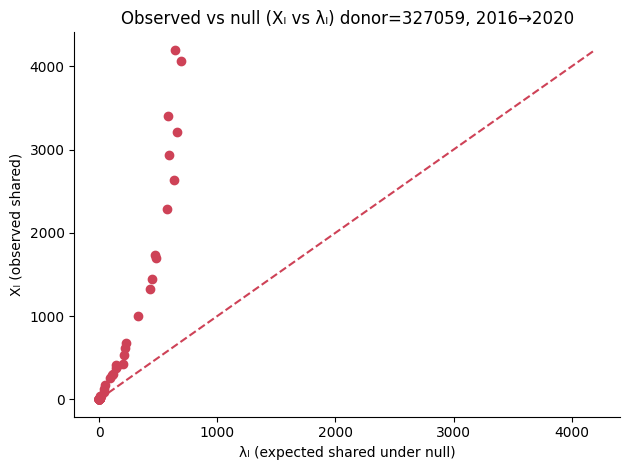

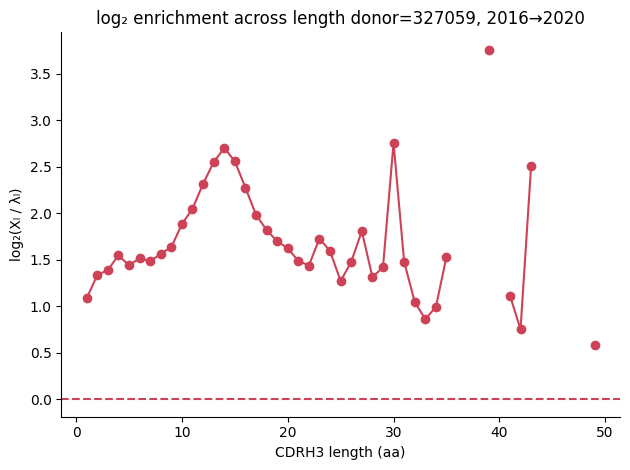

In [35]:
plot_counts_vs_lambda(res_df_d1, color='#ce4257', save_path='./figS5E.svg')
plot_log2_enrichment(res_df_d1, color="#ce4257", save_path='./figS5F.svg')

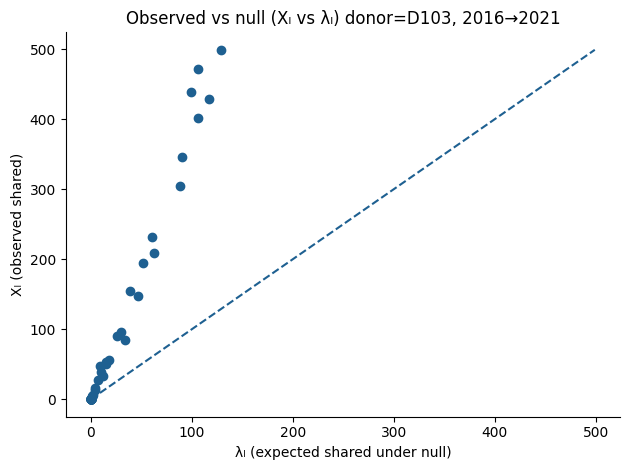

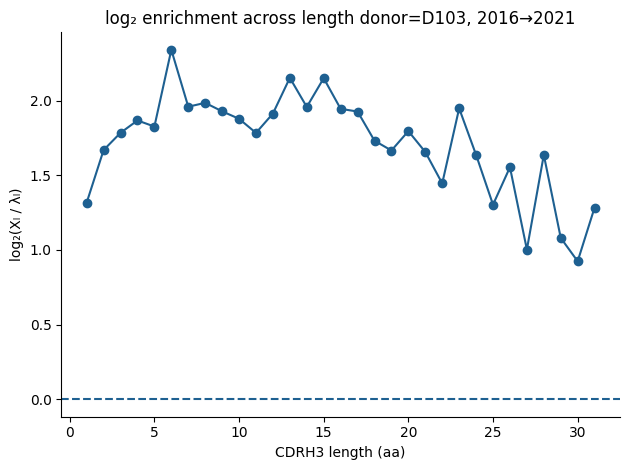

In [36]:
plot_counts_vs_lambda(res_df_d2, save_path='./figS5G.svg')
plot_log2_enrichment(res_df_d2, save_path='./figS5H.svg')